# Top_5 vs. Top_1 Correctness

* MobileNetV2를 활용한 ImageNet 분류

In [1]:
import warnings
warnings.filterwarnings('ignore')

> ## Import Packages

In [2]:
import tensorflow
import numpy as np

# I. Tensorflow Hub

* 사전 훈련된 MobileNetV2

In [3]:
import tensorflow_hub as hub

url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'

MbNetV2 = tensorflow.keras.Sequential([hub.KerasLayer(handle = url,
                                                      input_shape = (224, 224, 3), 
                                                      trainable = False)])

* Model Summary

In [4]:
MbNetV2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


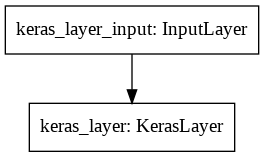

In [5]:
from tensorflow.keras import utils

utils.plot_model(MbNetV2)

# II. ImageNetV2 TopImages

> ## 1) 이미지(ImageNetV2) 다운로드

* 1000가지 객체에 대한 이미지 10장씩 구성
 -  약 2분

In [6]:
%%time

import os

image_url = 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-top-images.tar.gz'
data_dir = '/content/'

data_root_orig = tensorflow.keras.utils.get_file('imagenetV2', 
                                                 image_url, 
                                                 cache_dir = data_dir, 
                                                 extract = True)

1245929472/1245927936 [==============================] - 33s 0us/step
CPU times: user 7.34 s, sys: 5.62 s, total: 13 s
Wall time: 38.5 s


* 다운로드 경로 확인

In [7]:
import pathlib
from glob import glob

data_root = pathlib.Path(glob('/content/datasets/*/')[0])
print(data_root)

/content/datasets/imagenetv2-top-images-format-val


* 이미지별 디렉토리 확인
 - 1000개

In [8]:
!ls /content/datasets/imagenetv2-top-images-format-val

0    155  211  269  325  382  439  496	552  609  666  722  78	 836  893  95
1    156  212  27   326  383  44   497	553  61   667  723  780  837  894  950
10   157  213  270  327  384  440  498	554  610  668  724  781  838  895  951
100  158  214  271  328  385  441  499	555  611  669  725  782  839  896  952
101  159  215  272  329  386  442  5	556  612  67   726  783  84   897  953
102  16   216  273  33	 387  443  50	557  613  670  727  784  840  898  954
103  160  217  274  330  388  444  500	558  614  671  728  785  841  899  955
104  161  218  275  331  389  445  501	559  615  672  729  786  842  9    956
105  162  219  276  332  39   446  502	56   616  673  73   787  843  90   957
106  163  22   277  333  390  447  503	560  617  674  730  788  844  900  958
107  164  220  278  334  391  448  504	561  618  675  731  789  845  901  959
108  165  221  279  335  392  449  505	562  619  676  732  79	 846  902  96
109  166  222  28   336  393  45   506	563  62   677  733  790  847  903

> ## 2) Image Label 다운로드

* 'ImageNetLabels.txt'

In [9]:
import pandas as pd

url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
DF = pd.read_table(url, header = None)

label_text = DF.values.reshape(-1)

* Label 확인
 - 1001개 주의!!!

In [10]:
print(len(label_text))
print(label_text[:5])
print(label_text[-5:])

1001
['background' 'tench' 'goldfish' 'great white shark' 'tiger shark']
['earthstar' 'hen-of-the-woods' 'bolete' 'ear' 'toilet tissue']


> ## 3) Image(X) vs. Label(y) 확인

* 이미지 랜덤 추출

In [11]:
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

random.choice(all_image_paths)

'/content/datasets/imagenetv2-top-images-format-val/795/b815b73e62990c8cc1ef1fd2c8508092387b74b4.jpeg'

* 9개의 Image vs. Label 출력

image_count: 10000


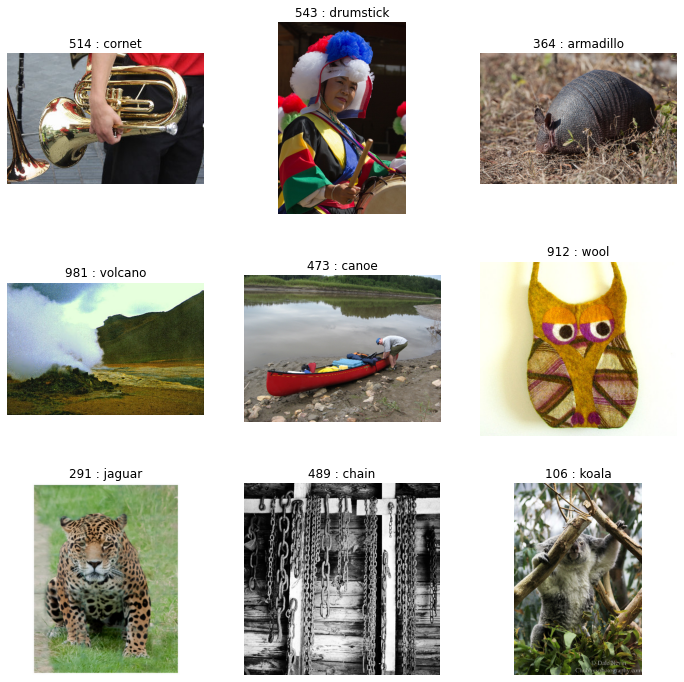

In [12]:
import PIL.Image as Image
import matplotlib.pyplot as plt

random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize = (12, 12))
for n in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3, 3 , n + 1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ' : ' + label_text[idx])
    plt.axis('off')
plt.show()

# III. MobileNet의 분류 라벨 확인

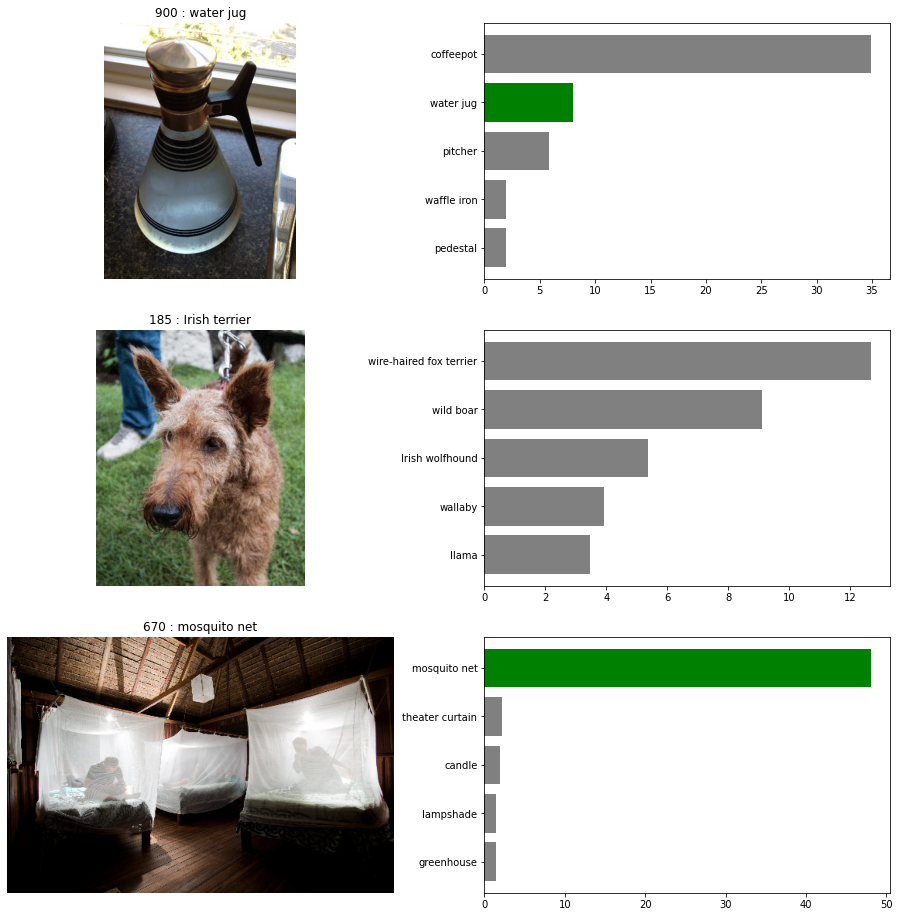

In [13]:
import cv2

plt.figure(figsize = (16, 16))

def softmax(x):
    m = np.max(x)
    sm = np.exp(x - m)/np.sum(np.exp(x - m))
    return sm
  
for n in range(3):
    # 랜던 이미지 경로 추출
    image_path = random.choice(all_image_paths)
    
    # 이미지 출력
    plt.subplot(3, 2, n * 2 + 1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ' : ' + label_text[idx])
    plt.axis('off')
    
    # Top-5 예측값 출력 공간 
    plt.subplot(3, 2 , n * 2 + 2)

    # 이미지 크기 변경 및 정규화
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize = (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis = 0)

    # MobileNetV2 이미지 분류
    logits = MbNetV2.predict(img)[0]
    prediction = softmax(logits)
    
    # Top-5 예측값
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [label_text[index] for index in top_5_predict]  

    # Top-5 막대그래프 색상 지정
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]

    # Top-5 막대그래프 출력
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color = color)
    plt.yticks(range(5), labels[::-1])

* np.argsort( )
 - 오름차순 정렬 후 Index 반환

In [14]:
AR = np.array([5555, 55, 5, 555])
print('오름차순 정렬 :', np.sort(AR), '\n')

arg = np.argsort(AR)
print('오름차순 정렬 후 Index :', arg, '\n')

print('argsort 결과 적용 :', AR[arg])

오름차순 정렬 : [   5   55  555 5555] 

오름차순 정렬 후 Index : [2 1 3 0] 

argsort 결과 적용 : [   5   55  555 5555]


# IV. MobileNetV2의 분류 성능 확인

* 약 9분

In [15]:
%%time

import cv2

top_1 = 0
top_5 = 0

for image_path in all_image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize = (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis = 0)

    top_5_predict = MbNetV2.predict(img)[0].argsort()[::-1][:5]
    idx = int(image_path.split('/')[-2]) + 1

    if idx in top_5_predict:
        top_5 =  top_5 + 1
        if top_5_predict[0] == idx:
            top_1 = top_1 + 1

print('Top-5 Correctness:', top_5 / len(all_image_paths) * 100, '%')
print('Top-1 Correctness:', top_1 / len(all_image_paths) * 100, '%')

Top-5 Correctness: 83.52000000000001 %
Top-1 Correctness: 59.06 %
CPU times: user 7min 7s, sys: 11.9 s, total: 7min 19s
Wall time: 7min 30s


# 
# 
# 
# The End
# 
# 
# 